# Classification and visualization of X-ray chest pathologies using DenseNet and GradCAM 

# Intorduction

In this project, a medical diagnosis of X-ray images will be performed to predict the occurrence of several chest pathologies, including: 
- Atelectasis         
- Cardiomegaly
- Consolidation
- Edema
- Effusion
- Emphysema
- Fibrosis
- Hernia
- Infiltration
- Mass

Classification will be conducted by the CNN DenseNet model and visualization of model activity will be done using GradCAMs. 
The project will consist of several steps, including pre-processing an X-ray dataset, handling class imbalance,  using transfer learning with DenseNet model, and measure diagnostic performance by computing the AUC (Area Under the Curve) for the ROC (Receiver Operating Characteristic) curve.

## Table of contents:


1. Loading and exploring the data
2. Preventing Data Leakage
3. Preparing images
4. Adressing Class Imbalance
5. Model development
6. Eveluating model performance
7. Visualizing Learning with GradCAM







# **1. Loading and exploring the data**

## **1.1. Import required packages**

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import os
from glob import glob
import shutil
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
import keras
import json
import nibabel as nib

from tensorflow.keras import backend as K2 
import tensorflow.python.keras.backend as K

#import util

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model

import random

import cv2
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## **1.2. Mounting / unmounting google drive in Colab**
The project was conducted in Google Colaboratory (Colab), providing free GPU resources, in integration with Google Drive for storing the image dataset and trained models.

In [2]:
# For more information see: https://colab.research.google.com/drive/1v42TP4CrZlzp5y9_4LHJdCc5QB9RXk5Q

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unmounting google drive from Colab
# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

## **1.3 Load the Datasets**
In this project, we will be using the ChestX-ray8 dataset which contains 108,948 frontal-view X-ray images of 32,717 unique patients.

Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions.
These in turn can be used by physicians to diagnose 8 different diseases.
We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies, i.e., The model will predict 'positive' or 'negative' for each of the pathologies.
The entire dataset can download in: https://nihcc.app.box.com/v/ChestXray-NIHCC

In this project We will use a ~1000 image subset of the images.
These can be accessed in the folder path stored in the IMAGE_DIR variable.
The dataset includes a CSV file that provides the labels for each X-ray.

For this small dataset, the labels were pre-processed, generating three new files:

nih/train-small.csv: 875 images from our dataset to be used for training.
nih/valid-small.csv: 109 images from our dataset to be used for validation.
nih/test.csv: 420 images from our dataset to be used for testing.
This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:

Consolidation
Edema
Effusion
Cardiomegaly
Atelectasis

In [6]:
train_df = pd.read_csv('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/train-small.csv')
valid_df = pd.read_csv('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/valid-small.csv')
test_df = pd.read_csv('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/test.csv')

# Looking on dataframes (Please note that the order of columns in the test_df differ from that in the train and valid_dfs) 
display(train_df.head())
display(valid_df.head())
display(test_df.head())

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [7]:
# Checking the data type in the different columns
train_df.dtypes

Image                 object
Atelectasis            int64
Cardiomegaly           int64
Consolidation          int64
Edema                  int64
Effusion               int64
Emphysema              int64
Fibrosis               int64
Hernia                 int64
Infiltration           int64
Mass                   int64
Nodule                 int64
PatientId              int64
Pleural_Thickening     int64
Pneumonia              int64
Pneumothorax           int64
dtype: object

## **1.4 Defining the labels**
Please note that the labels need to be in an order similar to the column order in the test_df. 

This is important for the prediction stage and evaluation of the model's performance using the ROC curve. 

In [8]:
print(len(test_df.columns))
print(test_df.columns)

16
Index(['Image', 'PatientId', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'],
      dtype='object')


In [9]:
# NOTE! the labels need to be in the order of coulumns as in the Test DataFrame

columns = list(train_df.columns)
print('number of columns:', len(columns) )
display(columns)

labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']


print('\n\nnumber of labels:', len(labels))
display(labels)

number of columns: 16


['Image',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'PatientId',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']



number of labels: 14


['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

## 1.5. Changing the data type of label columns from int64 to float32.
This is done for the training process that requires that the x (images) and y (labels) will be of the same type (in the matmul operation)

In [10]:
# Changing train_df dtype
for col in labels: 
    train_df = train_df.astype({col:'float32'})

display(train_df.dtypes)

Image                  object
Atelectasis           float32
Cardiomegaly          float32
Consolidation         float32
Edema                 float32
Effusion              float32
Emphysema             float32
Fibrosis              float32
Hernia                float32
Infiltration          float32
Mass                  float32
Nodule                float32
PatientId               int64
Pleural_Thickening    float32
Pneumonia             float32
Pneumothorax          float32
dtype: object

In [ ]:
# Changing valid_df dtype
for col in labels: 
    valid_df = valid_df.astype({col:'float32'})

display(valid_df.dtypes)

Image                  object
Atelectasis           float32
Cardiomegaly          float32
Consolidation         float32
Edema                 float32
Effusion              float32
Emphysema             float32
Fibrosis              float32
Hernia                float32
Infiltration          float32
Mass                  float32
Nodule                float32
PatientId               int64
Pleural_Thickening    float32
Pneumonia             float32
Pneumothorax          float32
dtype: object

In [ ]:
# Changing test_df dtype
for col in labels: 
    test_df = test_df.astype({col:'float32'})

display(test_df.dtypes)

Image                  object
PatientId               int64
Cardiomegaly          float32
Emphysema             float32
Effusion              float32
Hernia                float32
Infiltration          float32
Mass                  float32
Nodule                float32
Atelectasis           float32
Pneumothorax          float32
Pleural_Thickening    float32
Pneumonia             float32
Fibrosis              float32
Edema                 float32
Consolidation         float32
dtype: object

# **2. Preventing Data Leakage**
The data set might contain several images for each patient. To prevent data leakage between the train, validation and test datasets, the dataset will be splitted based on patient ID, and not image number.   

## **2.1. Define a function for Checking data leakage**

In [ ]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])

    # df1_patients_unique = set(df1[patient_col].values)
    # df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    if len(patients_in_both_groups) == 0:
        leakage = False
    else:
        leakage = True

    return leakage

### 2.1.1. Testing the check_for_leakage() function

In [ ]:
# test True leakage
print("True test case")
df1 = pd.DataFrame({'patient_id':[0,1,2]})
df2 = pd.DataFrame({'patient_id':[2,3,4]})
print("df1")
display(df1)
print('df2')
display(df2)
print(f"leakage output: {check_for_leakage(df1,df2,'patient_id')}")
print("\n__________________________________________________________________\n")

# test False leakage
print("False test case")
df1 = pd.DataFrame({'patient_id':[0,1,2]})
df2 = pd.DataFrame({'patient_id':[3,4,5]})
print("df1")
display(df1)
print('df2')
display(df2)
print(f"leakage output: {check_for_leakage(df1,df2,'patient_id')}")


True test case
df1


,patient_id
0,0
1,1
2,2


df2


,patient_id
0,2
1,3
2,4


leakage output: True

__________________________________________________________________

False test case
df1


,patient_id
0,0
1,1
2,2


df2


,patient_id
0,3
1,4
2,5


leakage output: False


## **2.2. Checking for data leakage in our data sets**

In [ ]:
print("Leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("Leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

Leakage between train and test: False
Leakage between valid and test: False


No data leakage is detected, and thus no images need to be tranfered from one dataset to another

# **3. Preparing images**


## **3.1.  Building a generator to the training set**
With our dataset splits ready, we can now proceed with setting up our model to consume them.

For this we will use the off-the-shelf ImageDataGenerator class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe.
This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is  0  and their standard deviation is 1.
This will facilitate model training by standardizing the input distribution.
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
We will want this because the pre-trained model that we'll use requires three-channel inputs.
For summary:

1. The  mean and standard deviation of the data will be normalized 
2. The input after each epoch is shuffled.
3. The image size is set to be 320px by 320px

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """ 
    print("Getting train generator:")
    # normalize images
    image_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

    # flow from directory with specified batch size and target image size
    # Pass any column/s as target data with class_mode=”raw”. Any data provided on a column or list of columns will be treated as raw target Numpy arrays.

    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode='raw',
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w,target_h))
    
    return generator

## **3.2. Building a generator to the valid and test sets**


We are not using the generator of the training set since it normalizes each image per batch, meaning that it uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage.
The model should not have any information about the test data.
What we need to do is normalize incoming test data using the statistics computed from the training set.

We implement this in the function below.
There is one technical note: ideally, we would want to compute our sample mean and standard deviation using the entire training set.
However, since this is extremely large, that would be very time consuming.
In the interest of time,  a random sample of the dataset will be used to calcualte the sample mean and sample standard deviation.

In [ ]:
# LOOK AT:  https://keras.io/api/preprocessing/image/

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100,
                                 batch_size=8, seed=1, target_w=320, target_h=320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print('Getting train and valid generator:')
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(dataframe=train_df,
                                                                   directory=IMAGE_DIR,
                                                                   x_col='Image',
                                                                   y_col=labels,
                                                                   class_mode="raw",
                                                                   batch_size=sample_size,
                                                                   shuffle=True,
                                                                   target_size=(target_w, target_h))
    # get data sample
    # (The next() function returns the next item from the iterator)
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get valid and test generators:
    valid_generator = image_generator.flow_from_dataframe(dataframe=valid_df,
                                                          directory=image_dir,
                                                          x_col=x_col,
                                                          y_col=y_cols,
                                                          class_mode='raw',
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          seed=seed,
                                                          target_size=(target_w, target_h))
    
    test_generator = image_generator.flow_from_dataframe(dataframe=test_df,
                                                          directory=image_dir,
                                                          x_col=x_col,
                                                          y_col=y_cols,
                                                          class_mode='raw',
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          seed=seed,
                                                          target_size=(target_w, target_h))
    return valid_generator, test_generator

## **3.3. Creating the training, validation and test generators**

In [ ]:
IMAGE_DIR = '/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/images-small'
train_generator = get_train_generator(train_df, IMAGE_DIR, 'Image', labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, 'Image', labels)

Getting train generator:
Found 1000 validated image filenames.
Getting train and valid generator:
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


## **3.4. Printing an example of the image generator output**
Looking into what the generator deliver our model during training and validation using the __get_item__(index) function:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


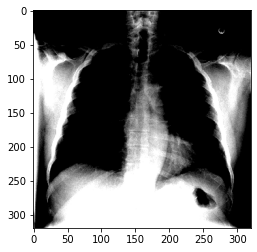

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])

In [ ]:
test_generator.__getitem__(0)[0].dtype

dtype('float32')

## **3.5. Visualizing images from the Train and Test sets**

Train set example images:
['00008270_015.png', '00029855_001.png', '00001297_000.png', '00012359_002.png', '00017951_001.png']
1000

Test set example images:
['00021463_005.png', '00019733_002.png', '00021463_001.png', '00017136_020.png', '00027477_000.png']
420


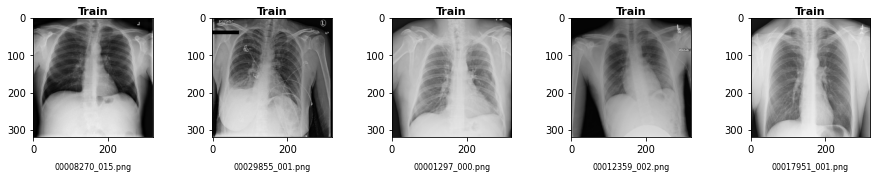

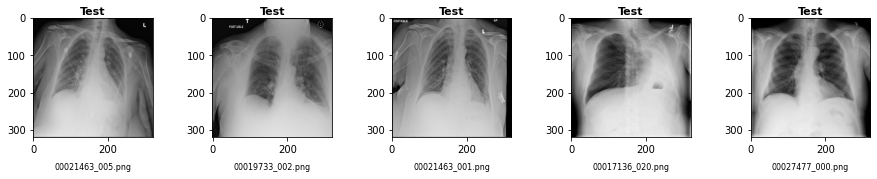

In [ ]:
# Plotting the first 5 images of the train set

mainDIR_train = list(train_df['Image'])
print("Train set example images:")
print(mainDIR_train[:5])
print(len(mainDIR_train))

mainDIR_test = list(test_df['Image'])
print("\nTest set example images:")
print(mainDIR_test[:5])
print(len(mainDIR_test))

fig_train, axes_train = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_train.flat):
    # saving the name of current image: 
    img_file_name_train = mainDIR_train[i]  
    # loading the image (using keras image class): 
    img_train = image.load_img("/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/images-small/"+img_file_name_train, target_size=(320,320)) 
    # displaying the images:
    ax.imshow(img_train)
    # adding an header text
    ax.text(0.5,1.05, str("Train"), color='black',fontsize=11,fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    # adding the current file name at the bottom of each image
    ax.text(0.5,-0.25, str(img_file_name_train), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


fig_test, axes_test = plt.subplots(1,5, figsize=(15, 15), gridspec_kw=dict(hspace=1.5, wspace=0.5))
for i, ax in enumerate(axes_test.flat):
    # saving the name of current image: 
    img_file_name_test = mainDIR_test[i]  
    # loading the image (using keras image class): 
    img_test = image.load_img("/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/images-small/"+img_file_name_test, target_size=(320,320)) 
    # displaying the images:
    ax.imshow(img_test)
    # adding an header text
    ax.text(0.5,1.05, str("Test"), color='black',fontsize=11,fontweight=560, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    # adding the current file name at the bottom of each image
    ax.text(0.5,-0.25, str(img_file_name_test), color='black',fontsize=8,fontweight=500, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# **4. Adressing Class Imbalance**
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. 

## **4.1. Plotting the frequency of each of the labels in our dataset:**

<function matplotlib.pyplot.show>

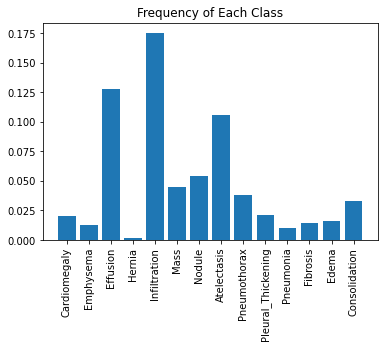

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show

## **4.2. Analysis of data imbalance**

In [ ]:
# The labels attribute of the DataGenerator return a numpy array with the values of the labels 

# Example of first image (row) label vlaues:
print('Example of first image (row) label vlaues:\n', train_generator.labels[1])
print()
# printing the mean of each column (axsis 0)
print('The mean of each column:\n', np.mean(train_generator.labels, axis=0))
print()
# Prining the sum of all means of each column --> 
#this sum to 0.675, meaning that 67.5% of cases have some kind of illness, whereas 32.5% are nomal cases (without any diagnosis)
positive_cases = np.sum(np.mean(train_generator.labels, axis=0)).round(2)
negative_cases = (1-positive_cases).round(2)

print('The sum of all means of each column: ', positive_cases)
print()
print(f"The sum is {positive_cases}, meaning that {positive_cases*100}% of cases have some kind of pathology, whereas {negative_cases*100}% are normal cases (without any diagnosis")
print()

# Printing the sum of each column (axsis 0)
print('The actual sum (not %) of positive cases of each column (pathology class):\n', np.sum(train_generator.labels, axis=0))
print()
# Printing the sum of all items in the labels 
print('The actual sum of positive cases in the training set:', np.sum(train_generator.labels))

Example of first image (row) label vlaues:
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

The mean of each column:
 [0.02  0.013 0.128 0.002 0.175 0.045 0.054 0.106 0.038 0.021 0.01  0.014
 0.016 0.033]

The sum of all means of each column:  0.67

The sum is 0.6700000166893005, meaning that 67.00000166893005% of cases have some kind of pathology, whereas 33.0% are normal cases (without any diagnosis

The actual sum (not %) of positive cases of each column (pathology class):
 [ 20.  13. 128.   2. 175.  45.  54. 106.  38.  21.  10.  14.  16.  33.]

The actual sum of positive cases in the training set: 675.0


### **4.2.1. Imbalance discussion**
We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies.

The Hernia pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%.
But even the Infiltration pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.
Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss.

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss.

### **4.2.2. Impact of class imbalance on loss function**

Assuming we would have used a normal cross-entropy loss for each pathology, the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

## **4.3. Computing Class Frequencies**
Defining a function that calculate the frequences for each label in our dataset

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N-np.sum(labels, axis=0))/N

    return positive_frequencies, negative_frequencies


### 4.3.1. Testing the compute_class_freqs() function

In [ ]:
labels_matrix = np.array(
    [[1,0,0],
     [0,1,1],
     [1,0,1],
     [1,1,1],
     [1,0,1]])

print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"Pos freqs {test_pos_freqs}")
print(f"Neg freqs {test_neg_freqs}")



labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
Pos freqs [0.8 0.4 0.8]
Neg freqs [0.2 0.6 0.2]


## **4.4. Compute frequencies for our training data**

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

print('Positive frequencies:\n', freq_pos)
print('\nNegative frequencies:\n',freq_neg)

Positive frequencies:
 [0.02  0.013 0.128 0.002 0.175 0.045 0.054 0.106 0.038 0.021 0.01  0.014
 0.016 0.033]

Negative frequencies:
 [0.98  0.987 0.872 0.998 0.825 0.955 0.946 0.894 0.962 0.979 0.99  0.986
 0.984 0.967]


### **4.4.1. Visualize these two contribution ratios next to each other for each of the pathologies:**

In [ ]:
# creating a data frame of all lables with the frequency of positive cases
data = pd.DataFrame({'Class': labels, "Label":"Positive", "Value": freq_pos})
#display(data)

# appending to DataFrame the frequency of negative cases of all lables 
data = data.append([{"Class":labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
display(data)

,Class,Label,Value
0,Cardiomegaly,Positive,0.020
1,Emphysema,Positive,0.013
2,Effusion,Positive,0.128
3,Hernia,Positive,0.002
4,Infiltration,Positive,0.175
5,Mass,Positive,0.045
6,Nodule,Positive,0.054
7,Atelectasis,Positive,0.106
8,Pneumothorax,Positive,0.038
9,Pleural_Thickening,Positive,0.021


### **4.4.2. Visualizing the data**

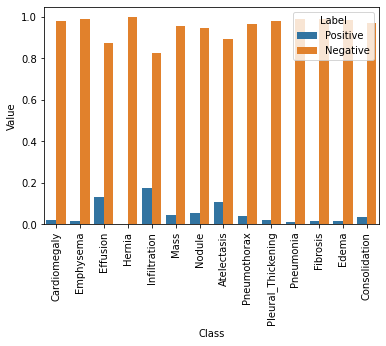

In [ ]:
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)

The above plot demonstrate that the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor,  Wpos  and  Wneg , so that the overall contribution of each class is the same. To have this, we want that:

W_pos×Freq_pos=W_neg×Freq_neg,
 
which we can do simply by:

W_pos=Freq_neg
 
W_neg=Freq_pos
 
## **4.5. Balancing the contribution of positive and negative labels**

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

### **4.5.1 Graphing the two weighted contributions next to each other again to verify balancing the data:**

,Class,Label,Value
0,Cardiomegaly,Positive,0.019600
1,Emphysema,Positive,0.012831
2,Effusion,Positive,0.111616
3,Hernia,Positive,0.001996
4,Infiltration,Positive,0.144375


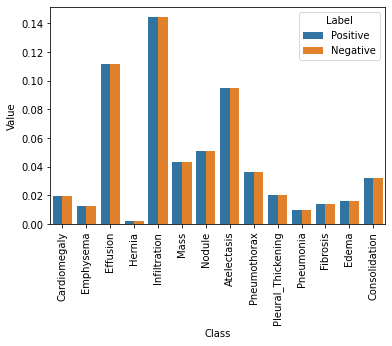

In [ ]:
data = pd.DataFrame({"Class": labels, "Label":"Positive", "Value":pos_contribution})
#display(data)

data = data.append([{"Class": labels[l], "Label": "Negative", "Value":v} for l,v in enumerate(neg_contribution)], ignore_index=True)
display(data.head())

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)


As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Next, such a loss function will be implemented. 

After computing the weights, the final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

## **4.6. Weighted Loss**
Defining the 'weighted_loss' function that return a loss function that calculates the weighted loss for each batch. Of note, for the multi-class loss, we add up the average loss for each individual class. In addition, a small value,  𝜖 , is added to the predicted values before taking their logs,  to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss (y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # intialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += K.mean(-1*pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon)) + K.mean(-1*neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))

        return loss

    return weighted_loss

### 4.6.1. Testing the 'Weighted Loss' function

In [ ]:
# test

sess = tf.compat.v1.Session()

with sess.as_default() as sess:
    print("Test example:\n")
    y_true = K2.constant(np.array(
        [[1,1,1],
         [1,1,0],
         [0,1,0],
         [1,0,1]]))
    print('y_true:\n')
    #Tensort.eval() is not working in this tf version
    #print(y_true.eval())

    # the following can be used instead
    print(K2.eval(y_true))
    #or just printing the tensor:
    print()
    print(y_true)

    w_p = np.array([0.25,0.25,0.5])
    w_n = np.array([0.75,0.75,0.5])
    print("\nw_p:")
    print(w_p)

    print("\nw_n:")
    print(w_n)
    
    y_pred_1 = K2.constant(0.7*np.ones(y_true.shape))
    print("\ny_pred_1")
    print(K2.eval(y_pred_1))

    y_pred_2 = K2.constant(0.3*np.ones(y_true.shape))
    print("\ny_pred_2")
    print(K2.eval(y_pred_2))

    # test with a large epsilon in order to catch errors
    L = get_weighted_loss(w_p, w_n, epsilon=0.5)

    print('\nif we weighted them correctly, the two losses will be the same.')
    L1 = K2.eval(L(y_true, y_pred_1))
    L2 = K2.eval(L(y_true, y_pred_2))
    print(f"\nL(y_pred_1)={L1:.4f}, L(y_pred_2)= {L2:.4f}")
    print(f"Difference is L1 - L2 = {L1 - L2:.4f}")
    

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

Tensor("Const:0", shape=(4, 3), dtype=float32)

w_p:
[0.25 0.25 0.5 ]

w_n:
[0.75 0.75 0.5 ]

y_pred_1
[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

if we weighted them correctly, the two losses will be the same.

L(y_pred_1)=0.0255, L(y_pred_2)= 0.0255
Difference is L1 - L2 = 0.0000


# **5. Model development**

## **5.1. Defining the model - DenseNet121**
The pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model will be used, which can be loaded directly from Keras, followed by adding two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

The custom loss function for the model will be then be used by specifying the `loss` parameter in the `compile()` function.

In [ ]:
# Create the base pro-trained model
base_model = DenseNet121(weights='/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])
#model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## **5.2. Training the model**
With our model ready for training, we will use the model.fit() function in Keras to train our model.

- We are training on a small subset of the dataset (~1%).
- Will plot the loss to make sure it is decreasing.

In [ ]:
history = model.fit(train_generator,validation_data=valid_generator,steps_per_epoch=100, validation_steps=25, epochs = 50)



Epoch 1/50
100/100 [==============================] - 380s 4s/step - loss: 0.6672 - accuracy: 0.1825 - val_loss: 2.2249 - val_accuracy: 0.4450
Epoch 2/50
100/100 [==============================] - 114s 1s/step - loss: 0.6055 - accuracy: 0.2288 - val_loss: 1.3695 - val_accuracy: 0.3050
Epoch 3/50
100/100 [==============================] - 64s 640ms/step - loss: 0.5765 - accuracy: 0.1825 - val_loss: 1.4471 - val_accuracy: 0.2550
Epoch 4/50
100/100 [==============================] - 64s 640ms/step - loss: 0.5377 - accuracy: 0.1925 - val_loss: 1.1853 - val_accuracy: 0.2850
Epoch 5/50
100/100 [==============================] - 64s 639ms/step - loss: 0.5535 - accuracy: 0.2150 - val_loss: 1.6373 - val_accuracy: 0.0650
Epoch 6/50
100/100 [==============================] - 64s 639ms/step - loss: 0.5327 - accuracy: 0.1637 - val_loss: 1.0611 - val_accuracy: 0.1550
Epoch 7/50
100/100 [==============================] - 64s 639ms/step - loss: 0.4609 - accuracy: 0.2400 - val_loss: 1.5431 - val_accura

## **5.3. Plot the loss**

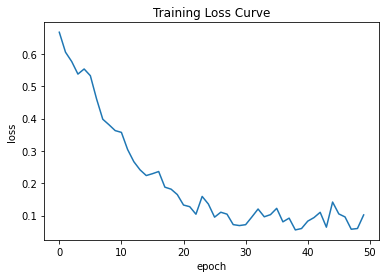

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

## **5.4. Define a function for plotting diagnostic learning curves**

In [ ]:
def summarize_diagnostics(history):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0,1.1)
    plt.legend()
    plt.show()
    ## if you want to save the plots to file, uncomment the following lines
    # filename = sys.argv.split('/')[-1]
    # plt.savefig(filename + '_plot.png')
    # plt.close()

## **5.5. Visualize the learning curve (accuracy and loss of the train and test sets**)

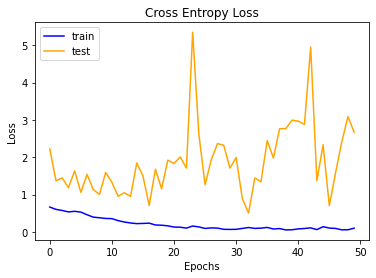

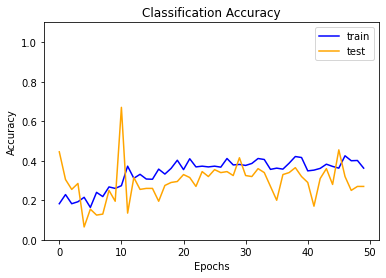

In [ ]:
summarize_diagnostics(history)

## **5.6. Saving the trained model**

In [ ]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

In [ ]:
# save model
model.save('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/densenet_small_image_50epochs.h5')

 ## **5.7. Recreate the model from the saved file and print model architecture**

When loading models that were trained using a costum built loss function, we need to specify and update a custom_objects argument in the load_model() function

for more information, see: 

https://github.com/keras-team/keras/issues/5916#issuecomment-294373616

https://stackoverflow.com/questions/45576576/keras-unknown-loss-function-error-after-defining-custom-loss-function


# **6. Eveluating model performance**

## **6.1. Defining a function that plot the ROC curve**

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:,i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10,10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf, label=labels[i] + ' (' + str(round(auc_roc, 3)) + ')')
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

## **6.2. Predicting and eveluating model performence trained on the small data set (1K images)**

### **6.2.1. Loading model that was trained using cosutum loss function**

In [ ]:
 # loading model that was trained using cosutum loss function - Option 2 that works (For TF1.0 version)
 from keras.utils.generic_utils import get_custom_objects

loss = get_weighted_loss(pos_weights, neg_weights)
densenet_small_image_model2 = tf.keras.models.load_model('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/densenet_small_image_50epochs.h5', custom_objects={"weighted_loss": loss})
#densenet_small_image_model2.summary()

In [ ]:
# # loading model that was trained using cosutum loss function - Option 1 that works (For TF2.3 vers )
# from keras.utils.generic_utils import get_custom_objects

# loss = get_weighted_loss(pos_weights, neg_weights)
# get_custom_objects().update({"weighted_loss": loss})

# densenet_small_image_model = load_model('/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/densenet_small_image_50epochs.h5')

### **6.2.2. Ploting the ROC curve**

In [ ]:
predicted_vals2 = densenet_small_image_model2.predict_generator(test_generator, steps = len(test_generator))

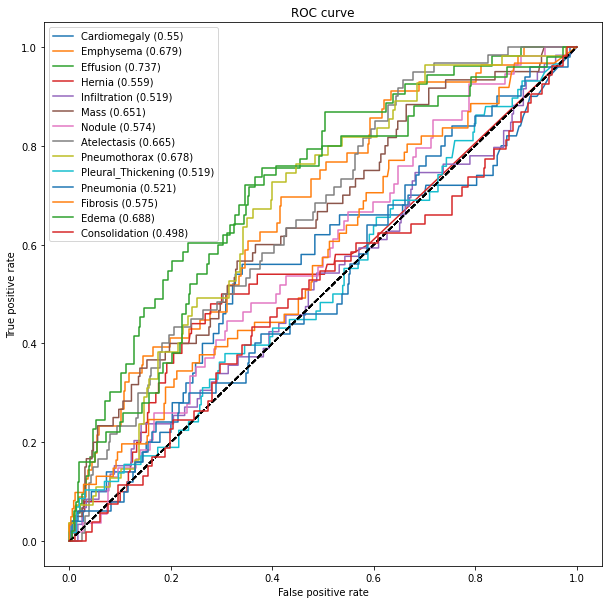

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals2, test_generator)

## **6.3. Training on the Larger Dataset (40K images)**
Given that the original dataset is 40GB+ in size and the training process on the full dataset takes a few hours, we will use weights that were obtained from training the model on a GPU-equipped machine (with a batch size of 32 instead).

The model architecture for our pre-trained model is exactly the same, but we used a few useful Keras "callbacks" for this training.

Useful tips for managing long-running training sessions:

1. You can use ModelCheckpoint callback to monitor your model's val_loss metric and keep a snapshot of your model at the point.
2. You can use the TensorBoard to use the Tensorflow Tensorboard utility to monitor your runs in real-time.
3. You can use the ReduceLROnPlateau to slowly decay the learning rate for your model as it stops getting better on a metric such as val_loss to fine-tune the model in the final steps of training.
4. You can use the EarlyStopping callback to stop the training job when your model stops getting better in it's validation loss. You can set a patience value which is the number of epochs the model does not improve after which the training is terminated. This callback can also conveniently restore the weights for the best metric at the end of training to your model.

For more information, see: https://keras.io/api/callbacks/.

### **6.3.1. Load the weights pre-trained on the large data set into the model**

In [ ]:
# Loading the DenseNet121 model that we pretrained on the large 40K images data set
model.load_weights("/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/pretrained_model.h5")
#densenet_LARGE_image_set_model.summary()

### **6.3.2. Making prediction**

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

### **6.3.3. Plotting the ROC curve**

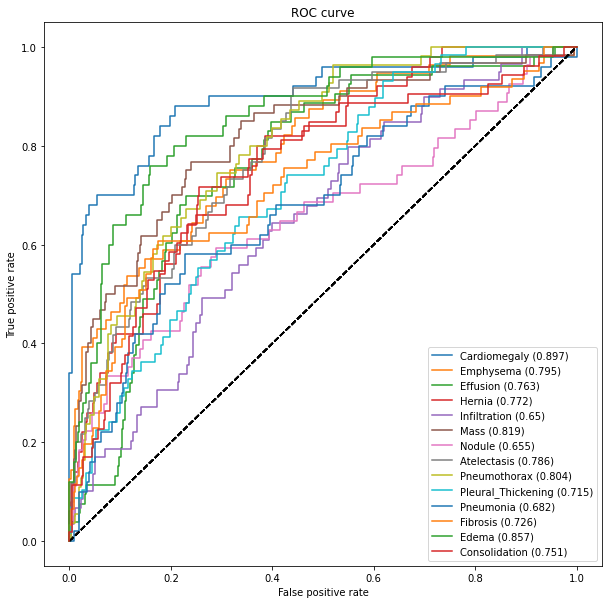

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

# **7. Visualizing Learning with GradCAM**

One of the challenges of using deep learning in medicine is that the complex architecture used for neural networks makes them much harder to interpret compared to traditional machine learning models (e.g. linear models).

One of the most common approaches aimed at increasing the interpretability of models for computer vision tasks is to use Class Activation Maps (CAM).

Class activation maps are useful for understanding where the model is "looking" when classifying an image.
In this section we will use a GradCAM's technique to produce a heatmap highlighting the important regions in the image for predicting the pathological condition.

This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer. The following functions below impliment this with the Keras framework.
Please note that GradCAM does not provide a full explanation of the reasoning for each classification probability.

However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.
First we will load the small training set and setup to look at the 4 classes with the highest performing AUC measures.

## **7.1. Defining functions for computing and visualizing GradCam**

### **7.1.1. Function for calculating the mean and std of images' values**
In this function, a sample of 100 images is selected from the data frame provided, and corresponding images are then loaded and appended to a sample_data list. Then, the mean and std are calculated using the image values in the list. The function returns the mean and std of sampled images.

In [ ]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

### **7.1.2. Function for loading and preprocessing images**

In [ ]:
def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

### **7.1.3. Function for implimenting the GradCAM method for visualizing input saliency**

In [ ]:
def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0] 
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

### **7.1.4. Define a function for computing and visualizing**

In [ ]:
def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

## **7.2. Load the small training set and setup to look at the 4 classes with the highest performing AUC measures**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/train-small.csv")
IMAGE_DIR = "/content/drive/My Drive/Chest_XRay_Pathologies_DensNet_GradCAM/nih/images-small/"

# only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

## **7.3. Looking at a few specific images with their GradCAM**

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


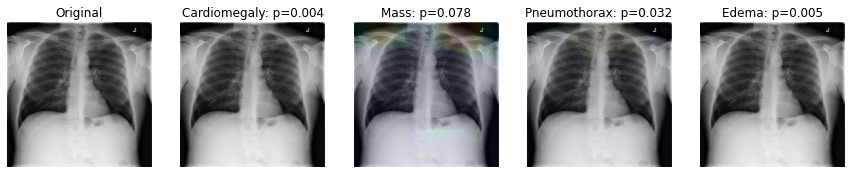

In [ ]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


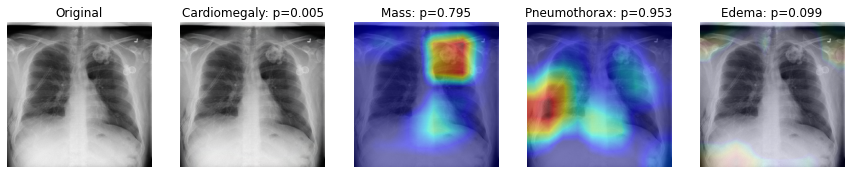

In [ ]:
compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


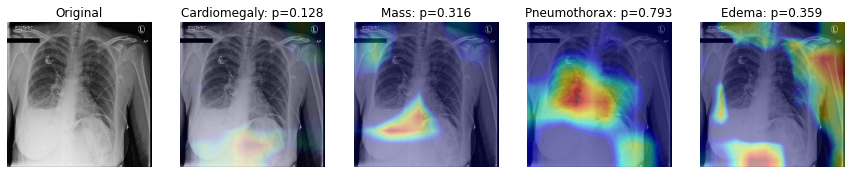

In [ ]:
compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


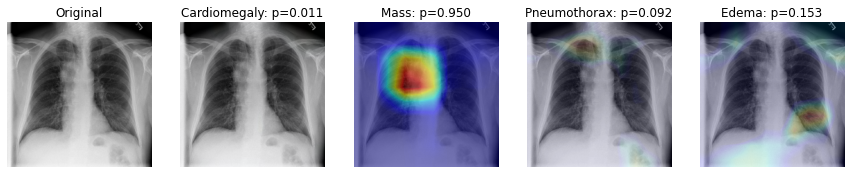

In [ ]:
compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)